In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

# path = '/content/drive/MyDrive/Thesis/home/shamiras/data/input/NRC-Emotion-Lexicon-v0.92-EnOnly.csv'
# path = './NRC-Emotion-Lexicon-v0.92-EnOnly.csv'
# em_lex = pd.read_csv(path)
# em_lex_list = list(em_lex[(em_lex['Positive'] == 1)]['English (en)'].values)

In [ ]:
def normalize_text(text):  # this is not a class method
    """Returns a normalized version of the specified string.
      Args:
        text (str): the text to normalize

      Returns:
        string. the normalized text.
    """
    text = text.lower()
    # text = text.replace("*", "")
    replacement_dict = {
        r"\t\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}(:\d{2})*\tandroid\n\d+\t\w+\t": " androidtimestamp ",  
        r"\n|\t": " ",
        r"http.+?(\\t|\s)": " URL ",  
        r"@\w+(.*?)\s": "@accountname\1 ",
        r"#\w+?(\s|\\t)": " #hashtag ",
        r"&amp;": " and ",
        r"\"": "",
        r"[():]": " , ",
        r";": " . ",  
        # r"\\\\\"|\"\\\\|\\\\|\\\s+\\": "",  # for obama speeches
        # r"´|…": "",
        r"$\d+": "$money",  # normalizing all money mentions to a single amount $SomeMoney
        r"(?i)\d{1,}:\d{2}(\s?)(a(\.?)m|p(\.?)m)": "hh:mm", # another option - \s\d{2}(.|:|-){1}\d{2}((.|:|-)\d{2}?)
        r"\d{2}(.|:|-){1}\d{2}": "dd-mm",  # normalizing dates
        r"(1\d{3})|(2\d{3})": "someyear",  # normalizing dates
        r"\d+": "number",  # normalizing numbers
        r"([.,!?()])": r" \1 ",  # padding after .,!?()
        r"\s*&mdash\s*": " ",  # removing long dash characters
        r"(\s*\.+)+": " . ",  # replacing each multiple '. . .' patterns with single ' . ' for simplicity
        r"\s{2,}": " ",  # removing extra spaces
        r"(?i)january|february|march|april|may|june|july|august|september|october|november|december": "somemonth",
        r"(?i)sunday|monday|tuesday|wednesday|thursday|friday|saturday": "someday"
    }

    for k, v in replacement_dict.items():
        text = re.sub(k, v, text)

    return text

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
import re
import pickle

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from copy import deepcopy

from torch import sigmoid, relu, no_grad
from torch import nn, optim, tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import load, save

TRAIN_PATH = './trump_train.tsv'
TEST_PATH = './trump_test.tsv'

# # if running in colab:
# TRAIN_PATH = '/content/drive/MyDrive/MSc/nlp/trump_train.tsv'
# TEST_PATH = '/content/drive/MyDrive/MSc/nlp/trump_test.tsv'

def load_best_model(file_name='./best_model_lstm'):
    '''Returns best performing model'''
    
    model = my_lstm(input_dim=100, hidden_size=30, batch_first=True,
                 num_layers=1, bidirectional=True)
    model.load_state_dict(load(file_name))
    return model

def train_best_model():
  '''Trains the best model from scratch'''
  # Preprocess df and prepare the dataframe
  TRAIN_PATH = './trump_train.tsv'
  df = preprocess(TRAIN_PATH, test=False)

  # Padding sequences
  X = nn.utils.rnn.pad_sequence(tuple(df['w2v_embedding_lstm_cut'].values), batch_first=True)
  y = df['label'].values

  # train-validation splitting
  test_size=0.3
  threshold_index = int((1-test_size) * X.shape[0])
  train, valid = X[:threshold_index], X[threshold_index:]
  target_train, target_valid = y[:threshold_index].astype(np.float32), y[threshold_index:].astype(np.float32)

  # convert to tensor and reshaping
  train, target_train, valid, target_valid = map(tensor, (train, target_train, valid, target_valid))

  # prepare DataLoaders
  train_ds = TensorDataset(train, target_train.reshape(-1,1))
  valid_ds = TensorDataset(valid, target_valid.reshape(-1,1))
  train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
  valid_dl = DataLoader(valid_ds, batch_size=64 * 2)

  # build and train model
  mylstm = my_lstm(train.shape[-1], hidden_size=30, batch_first=True,
                  num_layers=1, bidirectional=True)

  opt = optim.Adam(mylstm.parameters())
  loss_func = F.binary_cross_entropy
  epochs = 40
  fit(epochs, mylstm, loss_func, opt, train_dl, valid_dl, return_best=True)
  return mylstm

def predict(m, fn):
    '''Returns a list of 0s (trump's tweet) and 1s (staffer's tweet)

    Args:
        m (classification model): classification model for trump's/staffer's tweets
        fn (str): full path to a test file (containing tweets for model-prediction)

    Returns:
        predictions (List): pythons' list of predictions (0s correspond to trump's tweet and 1s to staffer's tweet)
    '''
    # load data and process
    test = preprocess(fn, test=True)

    # Padding sequences
    X_test = nn.utils.rnn.pad_sequence(tuple(test['w2v_embedding_lstm_cut'].values), batch_first=True)

    pred = m(X_test)
    pred = pred.flatten().detach().tolist()
    pred = list(map(int, np.round(pred)))

    return pred

def tweet2vec(t, model, mean=True):
  '''
  convert text to sequence of vectors or one averaged vector by word2vec.
  if mean is True return the average vector. else, return sequence of vectors.
  '''
  vectors = []
  for w in t.split():
    try:
      vectors.append(model[w])
    except:
      continue
  if mean:
    return np.mean(vectors, axis=0)
  else:
    return np.asarray(vectors)


def load_w2v_model(path = './w2v_model.txt'):
  with open(path, 'r') as f:
    lines = f.readlines()

  w2v_model = {l.split()[0]: [float(v) for v in l.split()[1:]] for l in lines[1:]}

  return w2v_model

def preprocess(fp, test=False):
    if test:
        df = pd.read_csv(fp, names=['handle', 'text', 'timestamp'], sep='\\t')
    else:
        df = pd.read_csv(fp, names=['tweet_id', 'handle', 'text', 'timestamp', 'device'], sep='\\t')
        # df['label'] = df.apply(lambda r: 0 if (r['device'] in ['android']) else 1, axis=1)
        df['label'] = df.apply(lambda r: 1 if (r['device'] in ['iphone']) else 0, axis=1)
        df.drop(columns=['tweet_id', 'device'], inplace=True)

    df.dropna(inplace=True)
    df['norm_text'] = df['text'].apply(lambda t: normalize_text(t))
    df['timestamp'] = df['timestamp'].apply(lambda ts: datetime.strptime(ts, "%Y-%m-%d %H:%M:%S"))
    df['cap_letters'] = df['text'].apply(lambda t: len([l for w in t.split() for l in w if l.isupper()])) # both cap_words and cap_words_normalized are not indicative, only result from len(tweet)
    df['cap_letters_norm'] = df['text'].apply(lambda t: len([l for w in t.split() for l in w if l.isupper()]) / len(t.split())) # both cap_words and cap_words_normalized are not indicative, only result from len(tweet)
    df['cap_words_normalized'] = df['text'].apply(lambda t: len([w for w in t.split() if w[0].isupper()]) / len(t.split()))
    df['num_!'] = df['text'].apply(lambda t: len([w for w in t.split() if '!' in w]))
    df['!_exists'] = df['text'].apply(lambda t: '!' in t)
    df['num_allcaps'] = df['text'].apply(lambda t: len([w for w in t.split() if w.isupper()]))
    df['allcaps_exist'] = df['text'].apply(lambda t: len([w for w in t.split() if w.isupper()]) > 0)
    df['len'] = df['norm_text'].apply(lambda t: len(t.split()))
    # df['time'] = df['timestamp'].apply(lambda t: t.time())
    df['time_idx'] = df['timestamp'].apply(lambda t: t.time().hour + t.time().minute / 60)
    df['num_@'] = df['text'].apply(lambda t: len([w for w in t.lower().split() if '@' in w]))
    # df['positive_words'] = df['norm_text'].apply(lambda t: len([w for w in t.split() if w in em_lex_list]))
    df['fake'] = df['text'].apply(lambda t: 'fake' in t.lower())
    df['count_fake'] = df['text'].apply(lambda t: len([w for w in t.split() if 'fake' in w.lower()]))
    df['dayofweek'] = df.timestamp.apply(lambda x: x.dayofweek)
    df['hour'] = df.timestamp.apply(lambda x: x.hour)

    # word2vec features
    w2v_model = load_w2v_model()
    df['w2v_embedding']      = df['norm_text'].apply(lambda t: tweet2vec(t, w2v_model))
    df['w2v_embedding_lstm'] = df['norm_text'].apply(lambda t: tweet2vec(t, w2v_model, mean=False))

    # cut all long tweets and convert to tensors
    cut_len_tweet = 55 # defined max len of sequence
    df['w2v_embedding_lstm_cut'] = df['w2v_embedding_lstm'].apply(lambda x: tensor(x[:cut_len_tweet].astype(np.float32)))
    
    # normalize
    for c in ['num_!', 'len', 'time_idx', 'num_@', 'count_fake', 'cap_words_normalized', 'cap_letters_norm', 'cap_letters',
              'num_allcaps', 'dayofweek', 'hour']: #'positive_words',
      mx = np.max(df[c])
      mn = np.min(df[c])
      rng = mx - mn
      df[c] = df[c].apply(lambda v: (v - mn) / rng)

    features = ['num_!','len', 'time_idx', 'num_@', 'count_fake', 'fake', 'num_allcaps', 'cap_words_normalized', 'cap_letters_norm','cap_letters', 'dayofweek', 'hour']#, 'positive_words'
    df['all_features'] = df.apply(lambda r: np.append(arr=r['w2v_embedding'], values=r[features].values.tolist()), axis=1).drop(columns="temp_features")

    return df

def normalize_text(text):  # this is not a class method
    """Returns a normalized version of the specified string.
      Args:
        text (str): the text to normalize

      Returns:
        string. the normalized text.
    """
    text = text.lower()
    # text = text.replace("*", "")
    replacement_dict = {
        r"\t\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}(:\d{2})*\tandroid\n\d+\t\w+\t": " androidtimestamp ",  
        r"\n|\t": " ",
        r"http.+?(\\t|\s)": " URL ",  
        r"@\w+(.*?)\s": "@accountname\1 ",
        r"#\w+?(\s|\\t)": " #hashtag ",
        r"&amp;": " and ",
        r"\"": "",
        r"[():]": " , ",
        r";": " . ",  
        # r"\\\\\"|\"\\\\|\\\\|\\\s+\\": "",  # for obama speeches
        # r"´|…": "",
        r"$\d+": "$money",  # normalizing all money mentions to a single amount $SomeMoney
        r"(?i)\d{1,}:\d{2}(\s?)(a(\.?)m|p(\.?)m)": "hh:mm", # another option - \s\d{2}(.|:|-){1}\d{2}((.|:|-)\d{2}?)
        r"\d{2}(.|:|-){1}\d{2}": "dd-mm",  # normalizing dates
        r"(1\d{3})|(2\d{3})": "someyear",  # normalizing dates
        r"\d+": "number",  # normalizing numbers
        r"([.,!?()])": r" \1 ",  # padding after .,!?()
        r"\s*&mdash\s*": " ",  # removing long dash characters
        r"(\s*\.+)+": " . ",  # replacing each multiple '. . .' patterns with single ' . ' for simplicity
        r"\s{2,}": " ",  # removing extra spaces
        r"(?i)january|february|march|april|may|june|july|august|september|october|november|december": "somemonth",
        r"(?i)sunday|monday|tuesday|wednesday|thursday|friday|saturday": "someday"
    }

    for k, v in replacement_dict.items():
        text = re.sub(k, v, text)

    return text

# fit model with the defined hyper parameters
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, return_best=False):
    best_model, loss_min = deepcopy(model), np.inf
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        if val_loss < loss_min:
          # save model state
          save(model.state_dict(), './best_model_tmp')
          loss_min = val_loss
        # print(epoch, val_loss)
    if return_best:
      model.load_state_dict(load('./best_model_tmp'))   

# calculate loss of specific batch, with defined loss function and optimizer
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

# define LSTM model class
class my_lstm(nn.Module):
  def __init__(self, input_dim, hidden_size, num_layers=1, bidirectional=False,
              batch_first=True):
    super().__init__()
    self.lstm = nn.LSTM(input_dim, hidden_size, num_layers,
                        bidirectional=bidirectional, batch_first=batch_first)
    self.lin1 = nn.Linear(hidden_size * (1+int(bidirectional)), int(hidden_size * 0.6))
    self.lin2 = nn.Linear(int(hidden_size * 0.6) , 1)
  
  def forward(self, x):
    x = relu(self.lstm(x)[0][:,-1,:])
    x = relu(self.lin1(x))
    x = sigmoid(self.lin2(x))
    return x

In [ ]:
def get_array_features(df, multi_cols=[], uni_cols=[]):
  '''
  take from df columns that contain lists\arrays, and regular columns that contain uni-value, and merged all to one 2-d numpy array.
  the parameters defined which features to take (might be just the columns that contain arrays, or the regular columns)
  Args:
    df - DataFrame with the columns
    multi_cols - list of columns names that contain arrays etc.
    uni_cols   - list of columns names that contain uni values.
  '''
  # convert all uni-cols to array
  if len(uni_cols) > 0:
    uni_features = df[uni_cols].values
  else:
    uni_features = np.array([]).reshape(len(df),0)

  # convert all multi-cols to array
  if len(multi_cols) > 0:
    multi_features = np.array(df[multi_cols[0]].tolist())
    if len(multi_cols[1:]) > 0:
      for col in multi_cols[1:]:
        multi_features = np.hstack((multi_features, np.array(df[col].tolist())))
  else:
    multi_features = np.array([]).reshape(len(df),0)
  
  # merge all arrays (uni & multi)
  return np.hstack((uni_features, multi_features))

In [ ]:
df = preprocess(TRAIN_PATH, test=False)
df.head()

,handle,text,timestamp,label,norm_text,cap_letters,cap_letters_norm,cap_words_normalized,num_!,!_exists,num_allcaps,allcaps_exist,len,time_idx,num_@,fake,count_fake,dayofweek,hour,w2v_embedding,w2v_embedding_lstm,w2v_embedding_lstm_cut,all_features
0,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,1,democrats are smiling in d . c . that the free...,0.037037,0.065217,0.458333,0.05,True,0.023256,True,0.037838,0.640919,0.000000,False,0.000000,1.0,0.652174,"[-0.4342173596153845, -0.1390680838846154, 0.4...","[[-0.27719215, -0.13077949, 0.28654286, 0.2045...","[[tensor(-0.2772), tensor(-0.1308), tensor(0.2...","[-0.4342173596153845, -0.1390680838846154, 0.4..."
1,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,1,general kelly is doing a great job at the bord...,0.012346,0.022684,0.173913,0.00,False,0.000000,False,0.032432,0.169798,0.000000,False,0.000000,0.0,0.173913,"[-0.5637518361538462, -0.1776679987076923, 0.4...","[[-0.36050308, -0.121594965, 0.23805527, 0.343...","[[tensor(-0.3605), tensor(-0.1216), tensor(0.2...","[-0.5637518361538462, -0.1776679987076923, 0.4..."
2,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,0,"the race for dnc chairman was , of course , to...",0.027778,0.053360,0.318182,0.05,True,0.023256,True,0.036486,0.565762,0.000000,False,0.000000,1.0,0.565217,"[-0.4356255919166668, -0.152111055125, 0.33020...","[[-0.22486667, -0.0873956, 0.3203062, 0.030871...","[[tensor(-0.2249), tensor(-0.0874), tensor(0.3...","[-0.4356255919166668, -0.152111055125, 0.33020..."
3,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,0,for first time the failing @accountname will ...,0.006173,0.010870,0.083333,0.05,True,0.000000,False,0.035135,0.572025,0.058824,False,0.000000,1.0,0.565217,"[-0.47171765200000004, -0.2225789562307692, 0....","[[-0.37221777, -0.270992, 0.46658748, 0.368697...","[[tensor(-0.3722), tensor(-0.2710), tensor(0.4...","[-0.47171765200000004, -0.2225789562307692, 0...."
4,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,0,"russia talk is fake news put out by the dems ,...",0.030864,0.046584,0.142857,0.05,True,0.046512,True,0.039189,0.846207,0.000000,True,0.333333,1.0,0.869565,"[-0.42673118933333337, -0.13287575003666666, 0...","[[-0.30834773, -0.105930775, 0.21402845, 0.282...","[[tensor(-0.3083), tensor(-0.1059), tensor(0.2...","[-0.42673118933333337, -0.13287575003666666, 0..."


### Train gensim Word2Vec Model using Trump Historical Tweets Data

In [ ]:
import gensim

with open('/content/drive/MyDrive/MSc/nlp/trump_historical_tweets.txt', 'r') as f:
  content = f.readlines()

train_sentences = [normalize_text(l) for l in content]
train_sentences = [s.split() for s in train_sentences]

model = gensim.models.Word2Vec(sentences=train_sentences, size=100, window=5, min_count=5)
model.wv.save_word2vec_format("/content/drive/MyDrive/MSc/nlp/w2v_model.txt")

In [ ]:
X = df[cols_for_model]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1. Logistic Regression

In [ ]:
params_grid = {
    'C': [1, 10, 100, 1000, 3000, 5000], 
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
}

cols_for_model = ['num_!',
                  'len', 
                  'time_idx', 
                  'num_@', 
                  'count_fake', 
                  'fake', 
                  'num_allcaps', 
                  'cap_words_normalized', 
                  'cap_letters_norm',
                  'cap_letters', 
                  'dayofweek', 
                  'hour']
                  
df = preprocess(TRAIN_PATH, test=False)

X = df[cols_for_model]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logistic = LogisticRegression(random_state=1)
clf = RandomizedSearchCV(logistic, param_distributions=params_grid, cv=10, scoring='accuracy', random_state=1, refit=True)
search = clf.fit(X_train, y_train)
print("Logistic Regression - best parameters found by randomized search:\n{}".format(search.best_params_))

logistic = LogisticRegression(**clf.best_params_, random_state=1).fit(X_train, y_train)
print("\nLogistic Regression - classification report for  best parameters:\n{}".format(classification_report(y_test, logistic.predict(X_test))))

Logistic Regression - best parameters found by randomized search:
{'solver': 'liblinear', 'penalty': 'l1', 'C': 100}

Logistic Regression - classification report for  best parameters:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       683
           1       0.83      0.47      0.60       276

    accuracy                           0.82       959
   macro avg       0.82      0.71      0.74       959
weighted avg       0.82      0.82      0.80       959



## 2. Support Vectors Classifier

### Non-Linear SVC

In [ ]:
params_grid = {
    'C': [1, 10, 100, 500, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'class_weight': ['balanced', None],
    'gamma': ['scale', 'auto']
}

df = preprocess(TRAIN_PATH, test=False)

X = np.array(df['w2v_embedding'].tolist())
y = df['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVC(random_state=1)
clf = RandomizedSearchCV(svm, param_distributions=params_grid, cv=10, scoring='accuracy', random_state=1, refit=True)

search = clf.fit(X_train, y_train)
print("Support Vectors - best parameters found by randomized search:\n{}".format(search.best_params_))

svm = SVC(**clf.best_params_, random_state=1).fit(X_train, y_train)
print("\nSupport Vectors - classification report for  best parameters:\n{}".format(classification_report(y_test, svm.predict(X_test))))

Support Vectors - best parameters found by randomized search:
{'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'C': 1000}
clf best params: {'kernel': 'poly', 'gamma': 'scale', 'class_weight': None, 'C': 1000}

Support Vectors - classification report for  best parameters:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       683
           1       0.74      0.54      0.62       276

    accuracy                           0.81       959
   macro avg       0.78      0.73      0.75       959
weighted avg       0.81      0.81      0.80       959



### Linear SVC

In [ ]:
params_grid = {
    'C': [1, 10, 100, 500, 1000],
    'kernel': ['linear'],
    'class_weight': ['balanced', None],
    'gamma': ['scale', 'auto']
}

df = preprocess(TRAIN_PATH, test=False)

X = np.array(df['w2v_embedding'].tolist())
y = df['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVC(random_state=1)
clf = RandomizedSearchCV(svm, param_distributions=params_grid, cv=10, scoring='accuracy', random_state=1, refit=True)

search = clf.fit(X_train, y_train)
print("Support Vectors - best parameters found by randomized search:\n{}".format(search.best_params_))

svm = SVC(**clf.best_params_, random_state=1).fit(X_train, y_train)
print("\nSupport Vectors - classification report for  best parameters:\n{}".format(classification_report(y_test, svm.predict(X_test))))

Support Vectors - best parameters found by randomized search:
{'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'C': 500}

Support Vectors - classification report for  best parameters:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       683
           1       0.83      0.43      0.57       276

    accuracy                           0.81       959
   macro avg       0.82      0.70      0.73       959
weighted avg       0.82      0.81      0.79       959



# Deep Models

In [ ]:
from torch import sigmoid, relu, no_grad
from torch import nn, optim, tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from torch import save, load

# fit model with the defined hyper parameters
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, return_best=False):
    best_model, loss_min = deepcopy(model), np.inf
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        if val_loss < loss_min:
          # save model state
          save(model.state_dict(), './best_model_tmp')
          loss_min = val_loss
          # best_model, loss_min = deepcopy(model), val_loss

        print(epoch, val_loss)
    if return_best:
      model.load_state_dict(load('./best_model_tmp'))   
      # model = best_model

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def evaluation(valid, target_valid, model):
  '''
  return (and print) evaluation metrics results
  '''
  # metrics
  with no_grad():
    pred   = np.round(model(valid).detach()).flatten()
    target = target_valid.detach().flatten()

    acc = accuracy_score(target, pred)
    rec = recall_score(target, pred)
    pre = precision_score(target, pred)
    f1 = f1_score(target ,pred)

  print(f'acc: {acc:.3f}. recall: {rec:.3f}. precision: {pre:.3f}. f1: {f1:.3f}')
  return acc, rec, pre, f1

## 3. NN Classifier

In [ ]:
class FNN(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.lin1 = nn.Linear(input_dim, int(input_dim * 1.5))
    self.lin2 = nn.Linear(int(input_dim * 1.5), int(input_dim * 0.5))
    self.lin3 = nn.Linear(int(input_dim * 0.5), 1)
  
  def forward(self, x):

    x = relu(self.lin1(x))
    x = relu(self.lin2(x))
    x = sigmoid(self.lin3(x))

    return x

MERGE FEATURES:

In [ ]:
features = ['num_!','len', 'time_idx', 'num_@', 'count_fake', 'fake', 'num_allcaps', 'cap_words_normalized', 'cap_letters_norm','cap_letters', 'dayofweek', 'hour']
X = get_array_features(df, multi_cols=['w2v_embedding'], uni_cols=features)
y = df['label'].values

In [ ]:
# load embedding vectors as features
# define train & test
train, valid, target_train, target_valid = train_test_split(X.astype(np.float32), y.astype(np.float32), test_size=0.3)

# convert to tensor and reshaping
train, target_train, valid, target_valid = map(
    tensor, (train, target_train, valid, target_valid))

train_ds = TensorDataset(train, target_train.reshape(-1,1))
valid_ds = TensorDataset(valid, target_valid.reshape(-1,1))

bs = 64
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [ ]:
model = FNN(input_dim = X.shape[1])
opt = optim.Adam(model.parameters())#, lr=lr)
loss_func = F.binary_cross_entropy
# loss_func = F.cross_entropy
epochs = 120
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

In [ ]:
evaluation(valid, target_valid, model)

acc: 0.843. recall: 0.740. precision: 0.820. f1: 0.778


(0.8425443169968717,
 0.7402234636871509,
 0.8204334365325078,
 0.7782672540381792)

In [ ]:
evaluation(valid, target_valid, model)

acc: 0.839. recall: 0.637. precision: 0.905. f1: 0.748


(0.8394160583941606,
 0.6368715083798883,
 0.9047619047619048,
 0.7475409836065574)

In [ ]:
evaluation(valid, target_valid, model)

acc: 0.819. recall: 0.565. precision: 0.890. f1: 0.691


(0.8185610010427529,
 0.5652173913043478,
 0.8904109589041096,
 0.6914893617021277)

In [ ]:
evaluation(valid, target_valid, model)

acc: 0.838. recall: 0.762. precision: 0.791. f1: 0.776


(0.8383733055265902,
 0.7620396600566572,
 0.7911764705882353,
 0.7763347763347762)

## 4. LSTM Classifier

In [ ]:
class my_lstm(nn.Module):
  def __init__(self, input_dim, hidden_size, num_layers=1, bidirectional=False,
               batch_first=True):
    super().__init__()
    self.lstm = nn.LSTM(input_dim, hidden_size, num_layers,
                        bidirectional=bidirectional, batch_first=batch_first)
    self.lin1 = nn.Linear(hidden_size * (1+int(bidirectional)), int(hidden_size * 0.6))
    self.lin2 = nn.Linear(int(hidden_size * 0.6) , 1)
  
  def forward(self, x):
    
    x = relu(self.lstm(x)[0][:,-1,:])
    x = relu(self.lin1(x))
    x = sigmoid(self.lin2(x))

    return x

In [ ]:
# def load_w2v_model(path = None):
#   with open('./w2v_model.txt', 'r') as f:
#     lines = f.readlines()

#   w2v_model = {l.split()[0]: [float(v) for v in l.split()[1:]] for l in lines[1:]}

#   return w2v_model

# w2v_model = load_w2v_model()

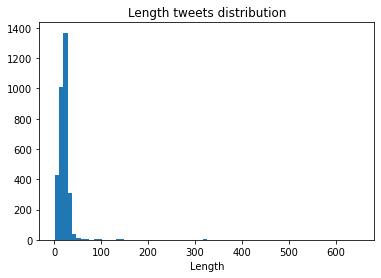

Just 0.91 %  of all tweets are longer than 55


In [ ]:
# visualiztion of tweets length
lengths = df['w2v_embedding_lstm'].apply(len)
plt.hist(lengths, bins=70), plt.title('Length tweets distribution'), plt.xlabel('Length')
plt.show()

threshold = 55
long_percent = 100 * len(lengths[lengths>threshold]) / len(lengths)
print(f'Just {long_percent:.2f} %  of all tweets are longer than {threshold}')

We can see that len=55 is sufficient for most of tweets. Longer tweets can be cut

In [ ]:
# Padding sequences
X = nn.utils.rnn.pad_sequence(tuple(df['w2v_embedding_lstm_cut'].values), batch_first=True)
y = df['label'].values

In [ ]:
test_size=0.3
threshold_index = int((1-test_size) * X.shape[0])
train, valid = X[:threshold_index], X[threshold_index:]
# threshold_index = int((1-test_size) * X.shape[1])
# train, valid = X[:, :threshold_index], X[:, threshold_index:]
target_train, target_valid = y[:threshold_index].astype(np.float32), y[threshold_index:].astype(np.float32)
# train, valid, target_train, target_valid = train_test_split(X.astype(np.float32), y.astype(np.float32), test_size=0.3)

In [ ]:
# convert to tensor and reshaping
train, target_train, valid, target_valid = map(
    tensor, (train, target_train, valid, target_valid))

train_ds = TensorDataset(train, target_train.reshape(-1,1))
valid_ds = TensorDataset(valid, target_valid.reshape(-1,1))

bs = 64
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
HIDDEN_SIZE = 45
NUM_LAYERS = 1
mylstm = my_lstm(train.shape[-1], HIDDEN_SIZE, batch_first=True,
                 num_layers=NUM_LAYERS, bidirectional=True)

In [ ]:
opt = optim.Adam(mylstm.parameters())
loss_func = F.binary_cross_entropy
# loss_func = F.cross_entropy
epochs = 45
fit(epochs, mylstm, loss_func, opt, train_dl, valid_dl, return_best=True)

0 0.6219745017316219
1 0.6213047936387803
2 0.6227929570379048
3 0.6174279940513675
4 0.5799962179006949
5 0.5792023944158624
6 0.6507650731253798
7 0.6196202588528861
8 0.5662109664756886
9 0.5519781479994622
10 0.5004408236464818
11 0.5706234915537431
12 0.4882987169578003
13 0.46760786480898653
14 0.4578306310741198
15 0.4427405935134331
16 0.42216372701249105
17 0.43114495271189496
18 0.408218357311921
19 0.3959164973717412
20 0.388402236763454
21 0.40149364487595307
22 0.382743198816918
23 0.38404985755775223
24 0.37011048698077237
25 0.3738638880479075
26 0.36686388736472264
27 0.3822647771323187
28 0.3739418125749256
29 0.3827458423046673
30 0.38942259941657964
31 0.378766611731214
32 0.3750938426341951
33 0.3717325453464878
34 0.37892475080937615
35 0.36758051208211684
36 0.36610384709643623
37 0.36492314589781855
38 0.36666131684628467
39 0.3659089293420253
40 0.3792715843949502
41 0.36481675981107914
42 0.36422776548158886
43 0.3612912028748251
44 0.3770177974069454


In [ ]:
model=mylstm
loss_func=F.binary_cross_entropy
with no_grad():
  losses, nums = zip(
          *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
  val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
val_loss

0.3612912028748251

In [ ]:
evaluation(valid, target_valid, mylstm) # 44 epochs, hidden=30, num_layers=2, bidirectional

acc: 0.854. recall: 0.679. precision: 0.827. f1: 0.745


(0.8540145985401459,
 0.6788079470198676,
 0.8266129032258065,
 0.7454545454545455)

In [ ]:
evaluation(valid, target_valid, mylstm) # 44 epochs, hidden=30, num_layers=2, bidirectional

acc: 0.851. recall: 0.636. precision: 0.853. f1: 0.729


(0.8508863399374348, 0.6357615894039735, 0.8533333333333334, 0.72865275142315)

In [ ]:
evaluation(valid, target_valid, mylstm) # 33 epochs, hidden=30, num_layers=2, bidirectional

acc: 0.860. recall: 0.682. precision: 0.844. f1: 0.755


(0.8602711157455682,
 0.6821192052980133,
 0.8442622950819673,
 0.7545787545787546)

In [ ]:
evaluation(valid, target_valid, mylstm) # 33 epochs, hidden=30, num_layers=2, bidirectional

acc: 0.857. recall: 0.679. precision: 0.837. f1: 0.750


(0.8571428571428571,
 0.6788079470198676,
 0.8367346938775511,
 0.7495429616087752)

In [ ]:
# save model state
save(mylstm.state_dict(), './best_model_lstm')

In [ ]:
# load data and process
test = preprocess('trump_test.tsv', test=True)

# Padding sequences
X_test = nn.utils.rnn.pad_sequence(tuple(test['w2v_embedding_lstm_cut'].values), batch_first=True)

pred = mylstm(X_test)

pred = pred.flatten().detach().tolist()
pred = np.round(pred)

In [ ]:
evaluation(valid, target_valid, mylstm) # 33 epochs, hidden=30, num_layers=2, bidirectional

acc: 0.851. recall: 0.834. precision: 0.784. f1: 0.809


(0.8508863399374348,
 0.8342541436464088,
 0.7844155844155845,
 0.8085676037483267)

In [ ]:
evaluation(valid, target_valid, mylstm) # 20 epochs, hidden=30, bidirectional

acc: 0.862. recall: 0.790. precision: 0.836. f1: 0.812


(0.862356621480709, 0.7900552486187845, 0.8362573099415205, 0.8125)

In [ ]:
evaluation(valid, target_valid, mylstm) # 25 epochs, hidden=30, bidirectional

acc: 0.847. recall: 0.655. precision: 0.915. f1: 0.763


(0.8467153284671532, 0.6546961325966851, 0.915057915057915, 0.7632850241545894)

In [ ]:
evaluation(valid, target_valid, mylstm) # 25 epochs, hidden=70, bidirectional

acc: 0.862. recall: 0.738. precision: 0.878. f1: 0.802


(0.862356621480709, 0.7375690607734806, 0.8782894736842105, 0.8018018018018017)

In [ ]:
evaluation(valid, target_valid, mylstm) # 35 epochs, hidden=15, bidirectional

acc: 0.856. recall: 0.699. precision: 0.897. f1: 0.786


(0.8561001042752867,
 0.6988950276243094,
 0.8971631205673759,
 0.7857142857142858)

## 5. Classifier of our Choice - Gradient Boosting

In [ ]:
params_grid = {
    'n_estimators': [5, 10, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [1, 3, 5, 10]}

cols_for_model = ['num_!',
                  'len', 
                  'time_idx', 
                  'num_@', 
                  'count_fake', 
                  'fake', 
                  'num_allcaps', 
                  'cap_words_normalized', 
                  'cap_letters_norm',
                  'cap_letters', 
                  'dayofweek', 
                  'hour']

# df = preprocess(TRAIN_PATH, test=False)

X = np.array(df['all_features'].tolist())
y = df['label'].tolist()

# X = df[cols_for_model]
# y = df['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gbt = GradientBoostingClassifier(random_state=1)
clf = RandomizedSearchCV(gbt, param_distributions=params_grid, cv=10, scoring='accuracy', random_state=1, refit=True)

search = clf.fit(X_train, y_train)
print("Gradient Boosting Tree - best parameters found by randomized search:\n{}".format(search.best_params_))

gbt = GradientBoostingClassifier(**clf.best_params_, random_state=1).fit(X_train, y_train)
print("\nGradient Boosting Tree - classification report for  best parameters:\n{}".format(classification_report(y_test, gbt.predict(X_test))))

Gradient Boosting Tree - best parameters found by randomized search:
{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

Gradient Boosting Tree - classification report for  best parameters:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       683
           1       0.80      0.50      0.61       276

    accuracy                           0.82       959
   macro avg       0.81      0.72      0.75       959
weighted avg       0.82      0.82      0.81       959



## Manual Analysis of Textual-Features

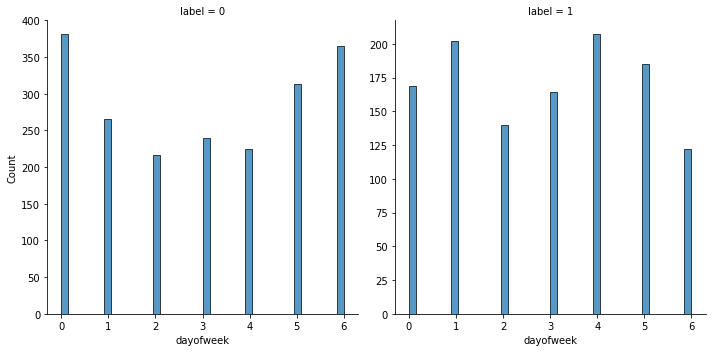

In [ ]:
sns.displot(data=df, x='dayofweek', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=False))

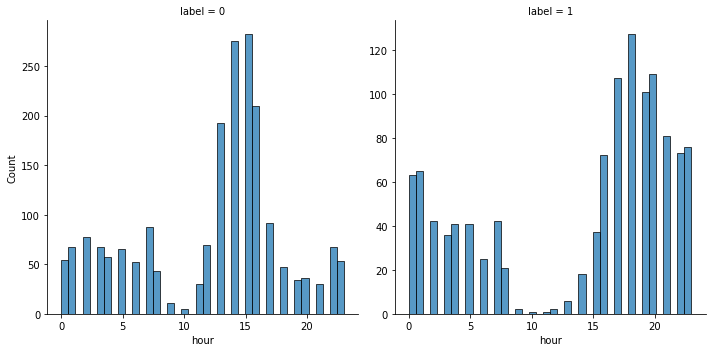

In [ ]:
sns.displot(data=df, x='hour', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=False))

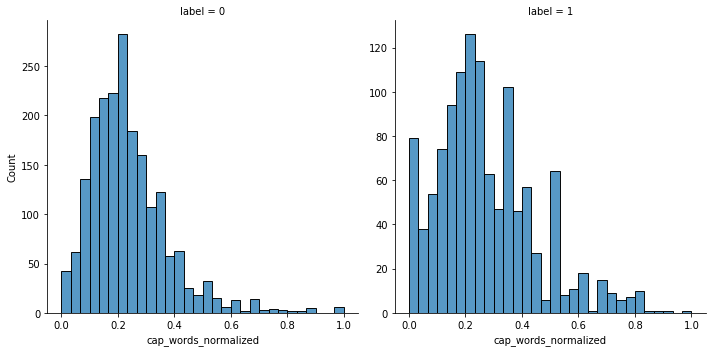

In [ ]:
sns.displot(data=df, x='cap_words_normalized', kind='hist', bins=30, col='label', facet_kws=dict(sharey=False, sharex=True))

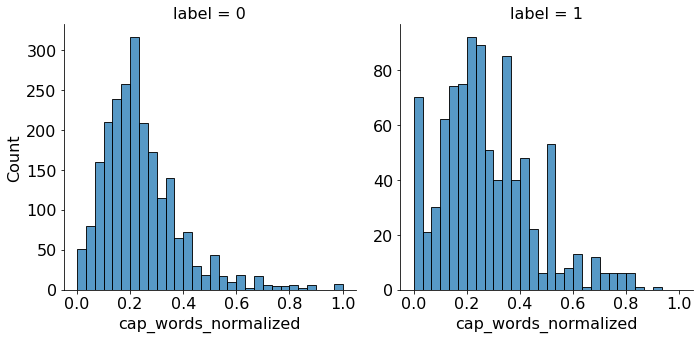

In [ ]:
#using web clients / instagram as trump tweets
sns.displot(data=df, x='cap_words_normalized', kind='hist', bins=30, col='label', facet_kws=dict(sharey=False, sharex=True))

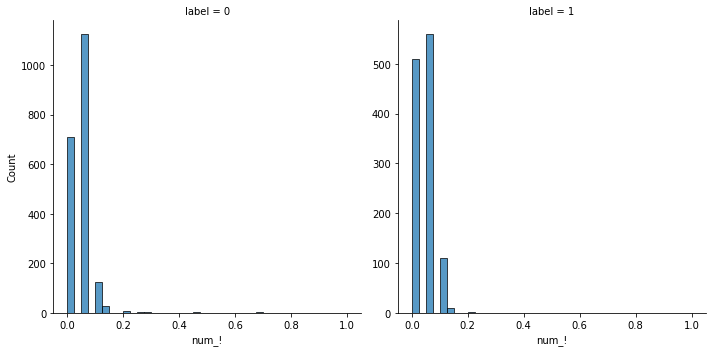

In [ ]:
sns.displot(data=df, x='num_!', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=True))

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


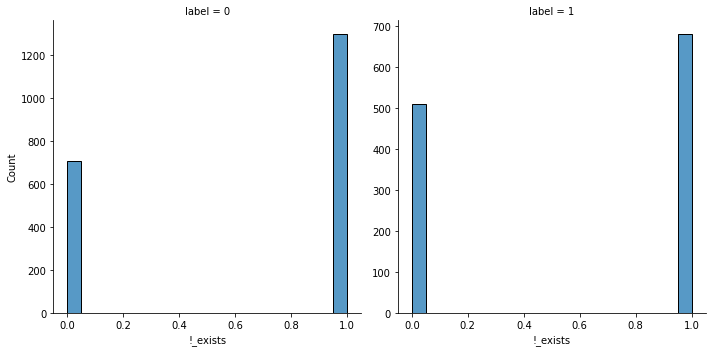

In [ ]:
sns.displot(data=df, x='!_exists', kind='hist', bins=20, col='label', facet_kws=dict(sharey=False, sharex=True))

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


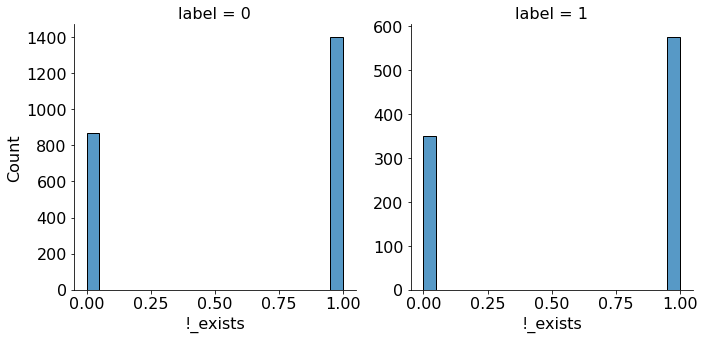

In [ ]:
#using web clients / instagram as trump tweets
sns.displot(data=df, x='!_exists', kind='hist', bins=20, col='label', facet_kws=dict(sharey=False, sharex=True))

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


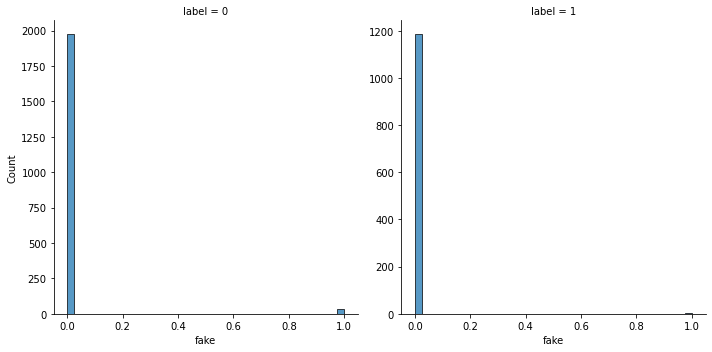

In [ ]:
sns.displot(data=df, x='fake', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=True))

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


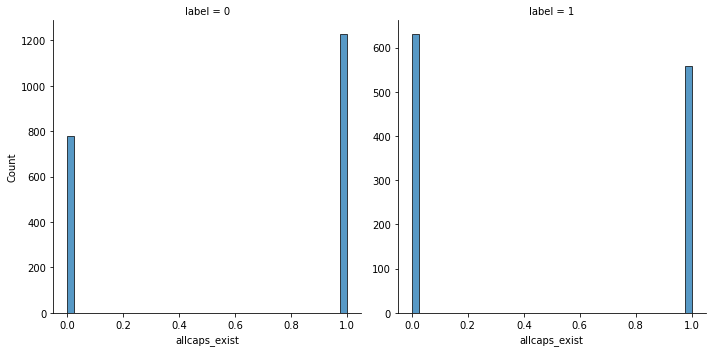

In [ ]:
sns.displot(data=df, x='allcaps_exist', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=True))

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


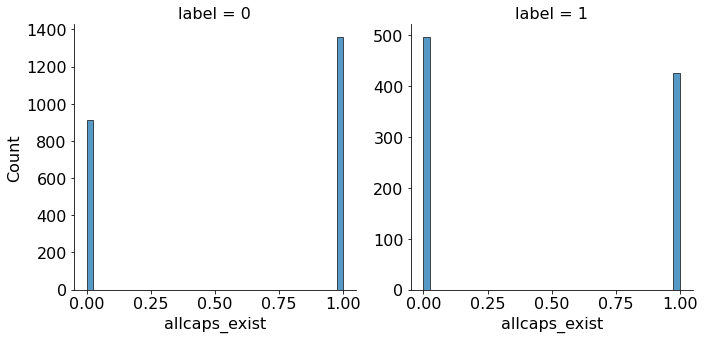

In [ ]:
#using web clients / instagram as trump tweets
sns.displot(data=df, x='allcaps_exist', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=True))

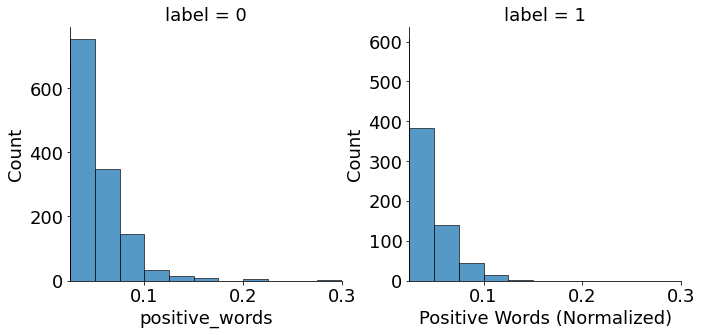

In [ ]:
sns.displot(data=df, x='positive_words', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=True))
plt.xlim((0.025, 0.3))
plt.xlabel("Positive Words (Normalized)")
plt.ylabel("Count")
plt.rcParams.update({'font.size': 16})

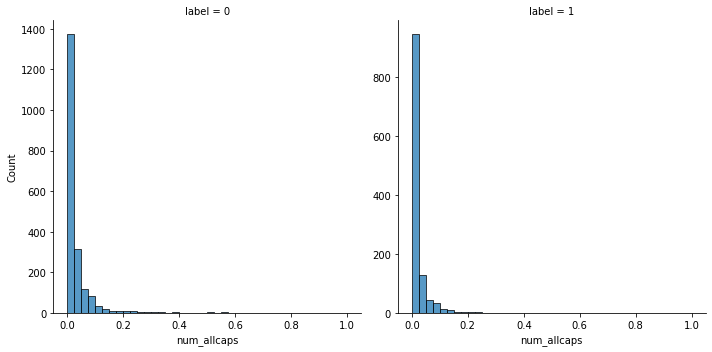

In [ ]:
sns.displot(data=df, x='num_allcaps', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=True))

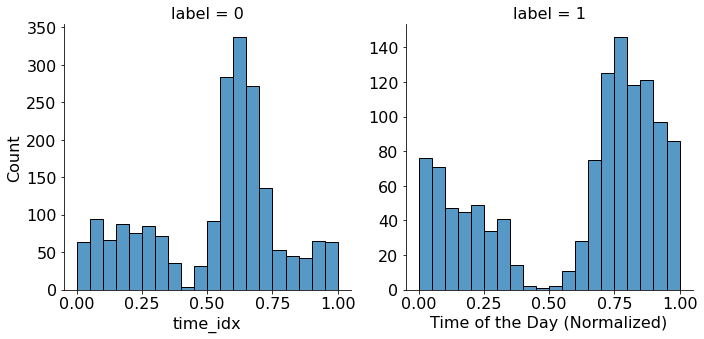

In [ ]:
sns.displot(data=df, x='time_idx', kind='hist', bins=20, col='label', facet_kws=dict(sharey=False, sharex=True))
plt.xlabel("Time of the Day (Normalized)")
plt.rcParams.update({'font.size': 16})

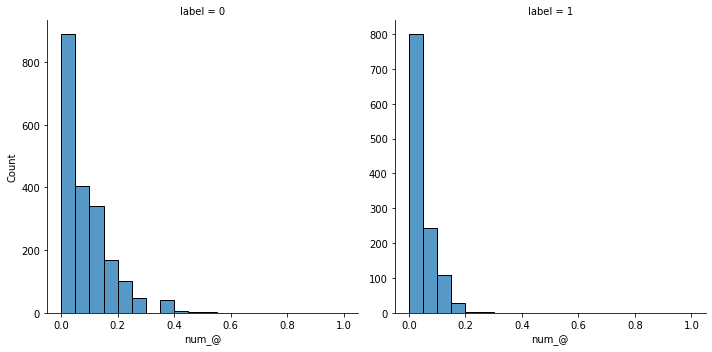

In [ ]:
sns.displot(data=df, x='num_@', kind='hist', bins=20, col='label', facet_kws=dict(sharey=False, sharex=True))

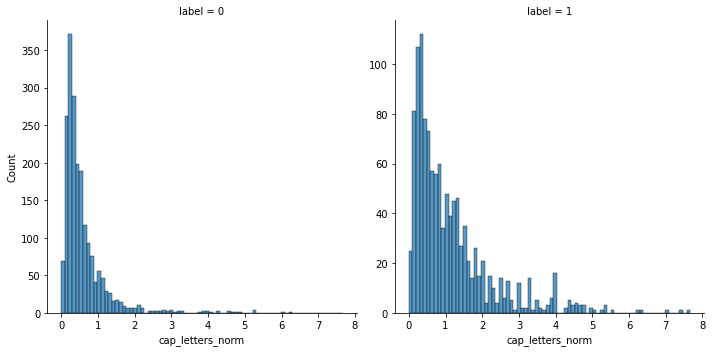

In [ ]:
sns.displot(data=df, x='cap_letters_norm', kind='hist', col='label', facet_kws=dict(sharey=False, sharex=False))

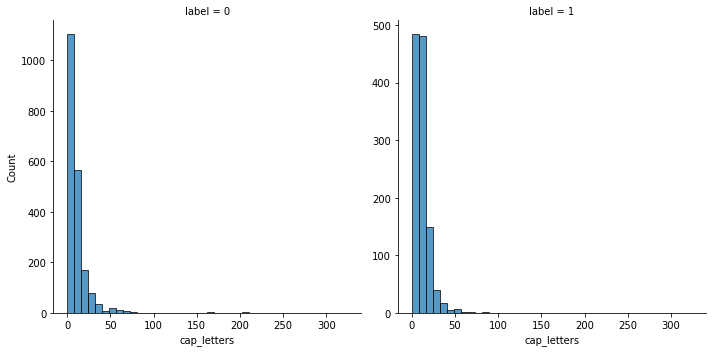

In [ ]:
sns.displot(data=df, x='cap_letters', kind='hist', bins=40, col='label', facet_kws=dict(sharey=False, sharex=False))

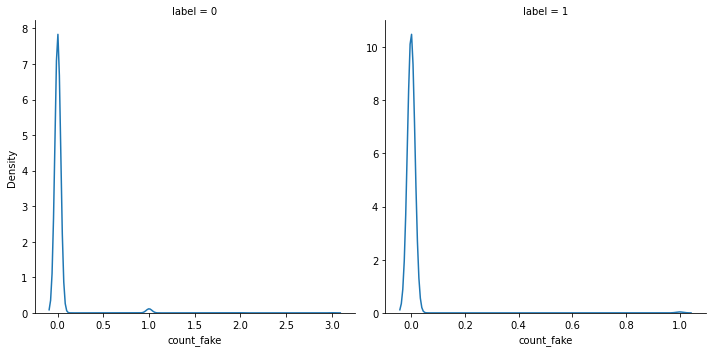

In [ ]:
sns.displot(data=df, x='count_fake', kind='kde', col='label', facet_kws=dict(sharey=False, sharex=False))

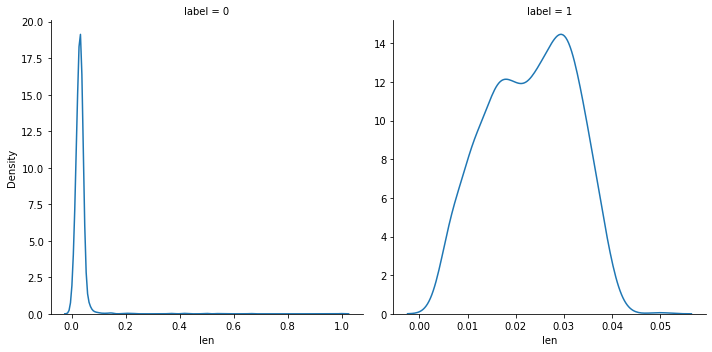

In [ ]:
sns.displot(data=df, x='len', kind='kde', col='label', facet_kws=dict(sharey=False, sharex=False))